In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import copy
import pylab as pl
import time as tlib
from IPython import display

#### Finding much accurately frequency by using Fourier Transforms even the frequency resolution is not high enough

#### The way do do it is.
1 Find the local high frequency.  
2 Get its phase  
**LHF** local high frequency  
**PH** phase  
**RU** resolution unit  
**Frequency = LHF + PH * RU / $\Pi$**

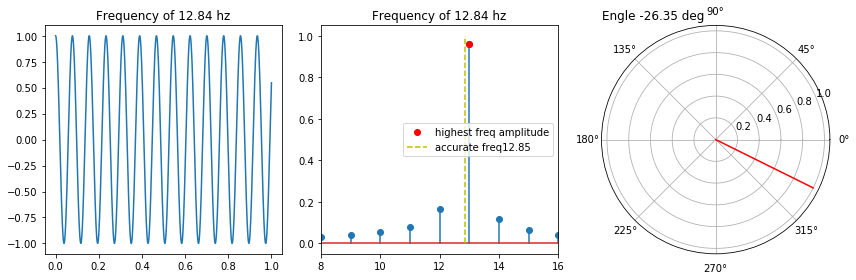

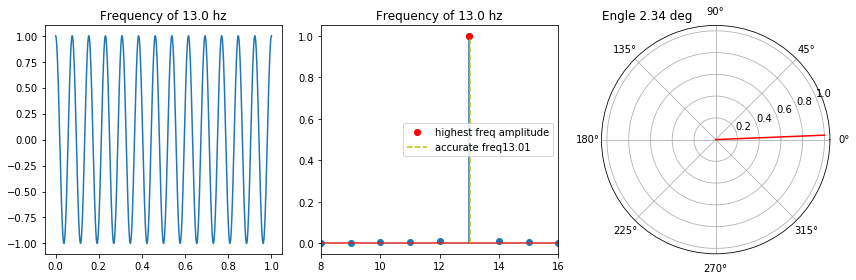

In [18]:
npnts = 1000
time = np.linspace(0, 1, npnts)

freqlen = 20
freqs = np.linspace(10, 13 , freqlen)
signals = np.zeros((freqlen, npnts))
for i in range(freqlen):
    signals[i] = np.cos(2*np.pi * freqs[i] * time)

hz = np.linspace(0, npnts / 2, int(npnts / 2) + 1)
spectrums = np.zeros((freqlen, npnts),dtype=np.complex)
for i in range(freqlen):
    spectrums[i] = scipy.fftpack.fft(signals[i])
    
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, projection='polar')

def showdata(i):
    spectrumAmplitude = np.abs(spectrums[i]) / npnts * 2 

    localMax = np.where( np.diff(np.sign(np.diff(spectrumAmplitude[:len(hz)]))) < 0)[0] + 1

    ang = np.angle(spectrums[i][localMax[0]])

    # Frequency = LHF + PH * RU /  Π
    accurateFrequency = hz[localMax[0]] + hz[1] * ang / np.pi

    ax1.clear()
    ax1.plot(time, signals[i])
    ax1.set_title('Frequency of {} hz'.format(np.round(freqs[i],2)))
    

    ax2.clear()
    ax2.stem(hz, np.abs(spectrumAmplitude[:len(hz)]))
    ax2.plot(hz[localMax], spectrumAmplitude[localMax], 'ro', label='highest freq amplitude')
    ax2.plot([accurateFrequency,accurateFrequency], [0,1], 'y--', label='accurate freq{}'.format(np.round(accurateFrequency,2)))
    ax2.set_xlim([8, 16])
    ax2.set_title('Frequency of {} hz'.format(np.round(freqs[i],2)))
    ax2.legend()
    
    ax3.clear()
    ax3.plot([0,ang],[0,1], 'r')
    ax3.set_title('Engle {} deg'.format(np.round(ang / np.pi * 180.0, 2)), loc='left')
    fig.tight_layout()
    

for i in range(freqlen - 1):
    
    showdata(i)
    display.clear_output(wait=True)
    display.display(pl.gcf())
#     tlib.sleep(.01)
    
showdata(freqlen - 1)

In [ ]:
start_freq = 770000
band_freq = 80000
duration = 0.0004
samples_one_second = 10000000
rate = samples_one_second / start_freq
sample = start_freq * rate
npnts = int(sample * duration)
light_speed = 300000